# Process Data

The intention in this notebook is to look into the process data. We'll perform some EDA such as Data Cleaning, Seperation and Outlier Detection and then start running some anomaly detection models on the data.

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gzip
import shutil
import datetime
import networkx as nx
import pickle
import pyclustering
from scipy import stats
import seaborn as sns
import bz2
import json
import random
random.seed(1134)

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

from IPython.display import clear_output

### Data

First we import our data. We import both process and authentication data incase the latter becomes useful down the line.

In [2]:
try:
    print('Attempting to read entire data set.')
    authentication_data = pd.read_csv('../Data/Authentication data.gz', compression='gzip', index_col = 0)
    process_data = pd.read_csv('../Data/Process data.gz', compression='gzip', index_col = 0)
except:
    clear_output()
    print('Unable to read entire data set, reading from original files.')
    rootdir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls'
    unzippeddir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls/Unzipped'
    frames = []

    count = 0

    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file[-3:] == '.gz':
                filedir = rootdir + '/' + file
                with gzip.open(filedir) as f:
                    df = pd.read_csv(filedir, header=None)
                    frames.append(df)
                if 'authentications' in str(file):
                    count = count + len(df)

    df = pd.concat(frames)

    authentication_data = df[:count]
    authentication_data.columns = ['UserName', 'SrcDevice','DstDevice', 'Authent Type', 'Failure', 'DailyCount']

    process_data = df[count:]
    process_data = process_data[[0,1,2,3,4]]
    process_data.columns = ['UserName', 'Device', 'ProcessName', 'ParentProcessName', 'DailyCount']

    authentication_data.to_csv('../Data/Authentication data.gz', header=True, compression='gzip')
    process_data.to_csv('../Data/Process data.gz', header=True, compression='gzip')

Attempting to read entire data set.


C:\Users\corri\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
rows = process_data.shape[0]
features = process_data.shape[1]
dp = process_data.shape[0] * process_data.shape[1]

print('The process data contains {} rows with {} features each. Thus we have {} data points.'.format(rows, features, dp))

The process data contains 55981618 rows with 5 features each. Thus we have 279908090 data points.


In [4]:
process_data.head()

,UserName,Device,ProcessName,ParentProcessName,DailyCount
0,Comp748297$,Comp748297,Proc391839.exe,Proc387473,1
1,Comp563664$,Comp563664,rundll32.exe,services,1
2,User607396,Comp609111,Proc417435.exe,Proc417435,1
3,Comp641702$,Comp641702,Proc249569.exe,services,1
4,Comp157389$,Comp157389,Proc402696.exe,services,1


### EDA

In [5]:
process_data.groupby('UserName').size().sort_values(ascending=False)

UserName
Scanner                 255383
User272607               73934
EnterpriseAppServer$     38552
Administrator            29443
User414014               18593
                         ...  
User711040                   1
User296343                   1
User464715                   1
User126086                   1
User252033                   1
Length: 25320, dtype: int64

In [6]:
process_data.groupby('Device').size().sort_values(ascending=False)

Device
EnterpriseAppServer    451831
Comp149394              28007
Comp460411              26771
Comp978490              25866
Comp897269              24757
                        ...  
Comp576558                  9
Comp530268                  8
Comp733749                  3
Comp772226                  2
Comp212946                  1
Length: 13476, dtype: int64

In [7]:
process_data.groupby('ProcessName').size().sort_values(ascending=False)

ProcessName
rundll32.exe      2325974
cscript.exe       1687233
Proc857443.exe    1644561
Proc364675.exe    1499525
conhost.exe       1231137
                   ...   
Proc542894.exe          1
Proc543189.exe          1
Proc543359.tmp          1
Proc543374              1
Proc000018.exe          1
Length: 25373, dtype: int64

In [8]:
process_data.groupby('ParentProcessName').size().sort_values(ascending=False)

ParentProcessName
services      12633664
svchost        5742175
None           4343007
Proc089893     3499148
taskeng        2496930
                ...   
Proc452325           1
Proc752276           1
Proc109173           1
Proc223040           1
Proc014122           1
Length: 12226, dtype: int64

We're going to find the index's to seperate out the days. Due to the way we created the large data set, we can search for the index 0 which tells us the start of every day.

In [9]:
index_list = process_data.index.tolist()
proc_start_days = [i for i, e in enumerate(index_list) if e == 0]
proc_start_days.append(len(process_data))

auth_index_list = authentication_data.index.tolist()
auth_start_days = [i for i, e in enumerate(auth_index_list) if e == 0]
auth_start_days.append(len(authentication_data))

Lets now seperate out day 1 and understand what we can do with the data.

In [10]:
process_day_1 = process_data[proc_start_days[0]:proc_start_days[1]]
process_day_1

,UserName,Device,ProcessName,ParentProcessName,DailyCount
0,Comp748297$,Comp748297,Proc391839.exe,Proc387473,1
1,Comp563664$,Comp563664,rundll32.exe,services,1
2,User607396,Comp609111,Proc417435.exe,Proc417435,1
3,Comp641702$,Comp641702,Proc249569.exe,services,1
4,Comp157389$,Comp157389,Proc402696.exe,services,1
...,...,...,...,...,...
605208,Comp267622$,Comp267622,svchost.exe,services,2
605209,User633443,Comp490773,Proc744059.exe,Proc510632,2
605210,User860048,Comp925644,Proc946021.exe,Proc442764,1
605211,User861156,Comp358133,Proc942581.exe,cmd,2


#### Isolation Through Red Team User Names List

In [11]:
rt_users = list(pd.read_csv('../Data/ProcessUserNames.txt', header=None)[0])

In [12]:
rt_process = process_data[process_data['UserName'].isin(rt_users)]
print('Red team events represent {}% of the data.'.format(100*rt_process.shape[0]/process_data.shape[0]))

Red team events represent 0.4111867577675229% of the data.


#### Daily Analysis

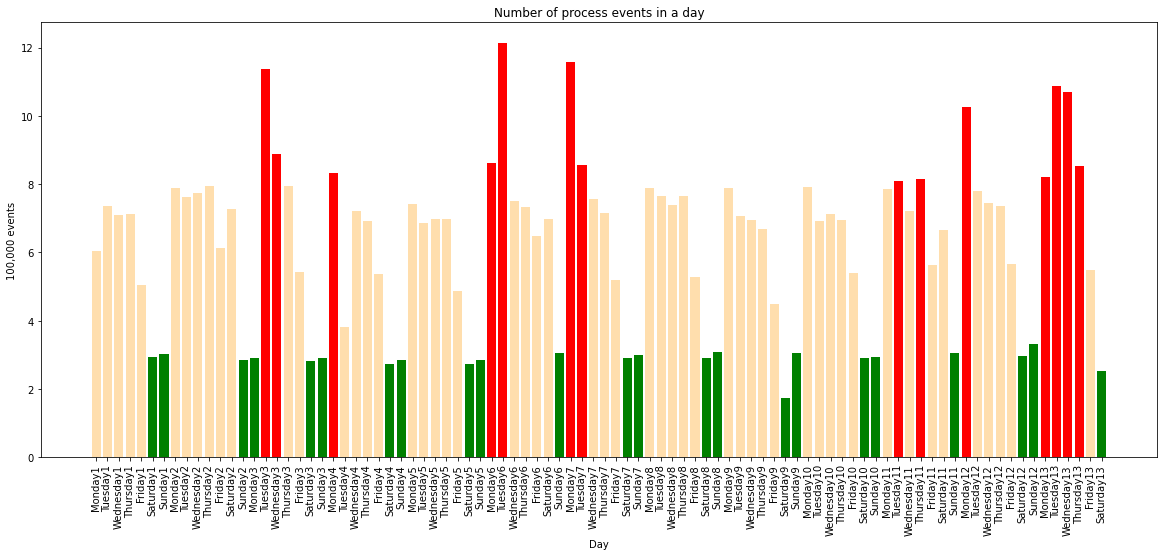

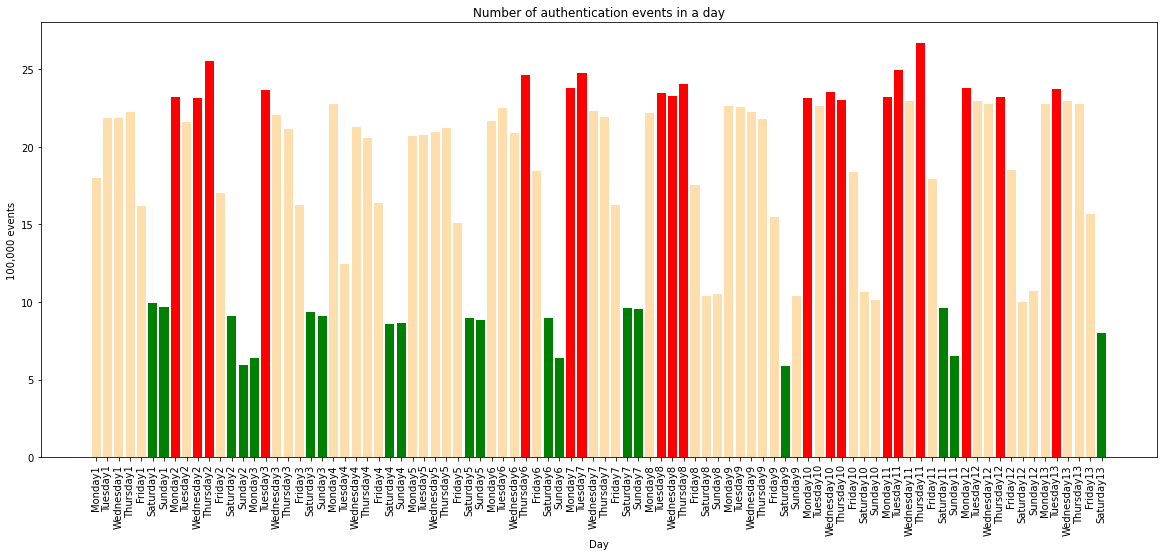

In [13]:
daily_process_counts = []
daily_auth_counts = []
proc_col = []
auth_col = []
day = []

for i in range(len(proc_start_days)-1):
    process_day = process_data[proc_start_days[i]:proc_start_days[i+1]]
    cnt = process_day.shape[0]
    daily_process_counts.append(cnt)
    
for i in range(len(auth_start_days)-1):
    auth_day = authentication_data[auth_start_days[i]:auth_start_days[i+1]]
    auth_cnt = auth_day.shape[0]
    daily_auth_counts.append(auth_cnt)

daily_process_counts = np.array(daily_process_counts)/100_000

daily_auth_counts = np.array(daily_auth_counts)/10_000

day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

for j,val in enumerate(daily_process_counts):
    if val < 3.5:
        proc_col.append('green')
    elif val >= 8:
        proc_col.append('red')
    else:
        proc_col.append('navajowhite')
        
    day.append(day_dict[j%7] + str(int(j/7)+1))
    
for j,val in enumerate(daily_auth_counts):
    if val < 10:
        auth_col.append('green')
    elif val >= 23:
        auth_col.append('red')
    else:
        auth_col.append('navajowhite')

    
plt.figure(figsize=(20,8))
plt.bar(day,daily_process_counts, color=proc_col)
plt.ylabel('100,000 events')
plt.xlabel('Day')
plt.xticks(rotation=90)
plt.title('Number of process events in a day')

plt.figure(figsize=(20,8))
plt.bar(day,daily_auth_counts, color=auth_col)
plt.ylabel('100,000 events')
plt.xlabel('Day')
plt.xticks(rotation=90)
plt.title('Number of authentication events in a day')
plt.show()

np.savetxt("DailyProcessCounts.csv", daily_process_counts, delimiter=",")

- The analysis is based on arbitrarily chosen thresholds and may change depending on how this is chosen. However, e see times of 'normal' during the week and 'low' during the weekend mostly with good regularity. There is a lot of periodicity in the counts here. We find some anomalous periods:
    - Week 3: Monday has a low amount of processes, and similarly in the authentication data, we see a low amount of authentications. This we are assuming is due to a day off such as a holiday.
    - Spikes often occur on Monday/Tuesday of each week, probably due to more work being done in this time.

We'll assess whether the working week schedule identified in the time off LANL period is shown in this data. We want to see whether there is a difference between every other Friday's values. We use Welch's test and the Kolmogorov Smirnov test to test whether the weeks are different.

In [14]:
fri_process = daily_process_counts[4::7]
w1_fri_process = fri_process[::2]
w2_fri_process = fri_process[1::2]

fri_auth = daily_auth_counts[4::7]
w1_fri_auth = fri_auth[::2]
w2_fri_auth = fri_auth[1::2]

proc_p_value_w = stats.ttest_ind(w1_fri_process,w2_fri_process)[1]
auth_p_value_w = stats.ttest_ind(w1_fri_auth,w2_fri_auth)[1]
comb_w = stats.combine_pvalues([proc_p_value_w,auth_p_value_w])[1]

proc_p_value_k = stats.kstest(w1_fri_process,w2_fri_process)[1]
auth_p_value_k = stats.kstest(w1_fri_auth,w2_fri_auth)[1]
comb_k = stats.combine_pvalues([proc_p_value_k,auth_p_value_k])[1]

print("We obtain a p-value for this test of: {}. Therefore we reject the null and state that there is a difference when using Welch's Test.".format(comb_w))
print("We obtain a p-value for this test of: {}. Therefore we reject the null and state that there is a difference when using the K-S Test.".format(comb_k))

We obtain a p-value for this test of: 0.0036332174085944593. Therefore we reject the null and state that there is a difference when using Welch's Test.
We obtain a p-value for this test of: 0.009257758105665117. Therefore we reject the null and state that there is a difference when using the K-S Test.


From the naked eye it looks like we have no real difference between the two weeks however both Welch's test and the Kolmogorov Smirnov test reject the hypothesis that the distributions of the data are the same. Thus we have a difference between the two weeks and from this data, employees at LANL do often work the 9 day split and have every other Friday off. This is something we will need to account for in our anomaly analysis.

### Graph Analysis

In [15]:
process_G = nx.from_pandas_edgelist(process_data,source="Device",target="UserName")

#### Degrees

In [16]:
degrees = pd.DataFrame([(n,d) for n,d in process_G.degree()])
degrees.columns = ['Device', 'Degree']
degrees = degrees.sort_values(by='Degree',axis=0,ascending=False)
degrees

,Device,Degree
29581,User272607,8946
848,EnterpriseAppServer,2752
240,Scanner,2355
4928,Comp291378,527
2990,Administrator,437
...,...,...
11928,Comp461730$,1
11931,Comp951154$,1
11933,Comp375354$,1
11935,Comp272704$,1


In [17]:
degrees_l2 = degrees[degrees['Degree'] >= 3]
degrees_l2

,Device,Degree
29581,User272607,8946
848,EnterpriseAppServer,2752
240,Scanner,2355
4928,Comp291378,527
2990,Administrator,437
...,...,...
25688,Comp162069,3
25875,Comp682438,3
1021,User001465,3
28189,User806400,3


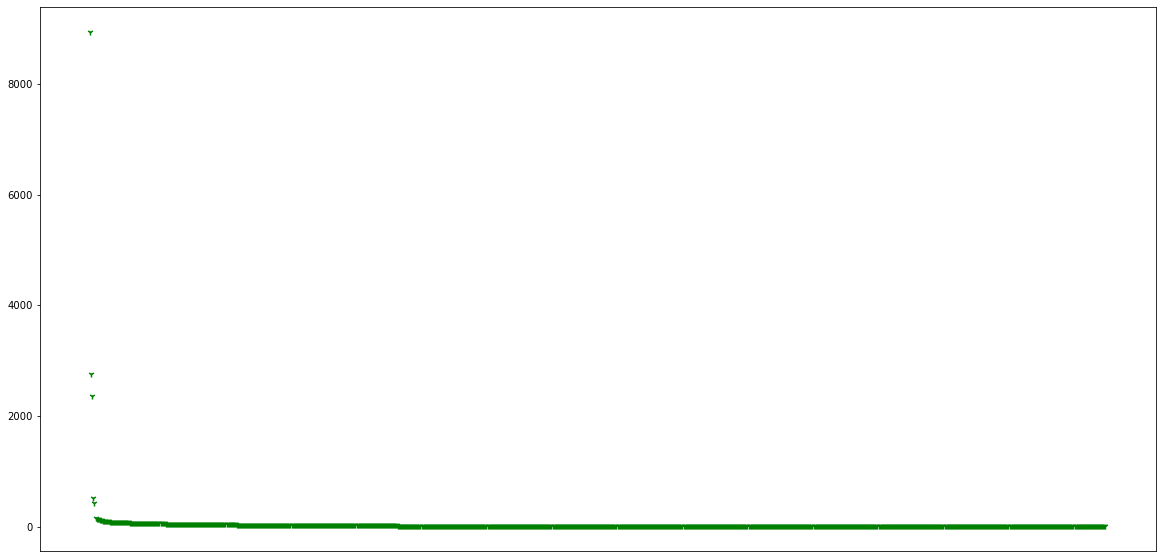

In [18]:
plt.figure(figsize=(20,10))
plt.scatter(degrees['Device'][:1000],degrees['Degree'][:1000], color='g', marker='1')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.show()

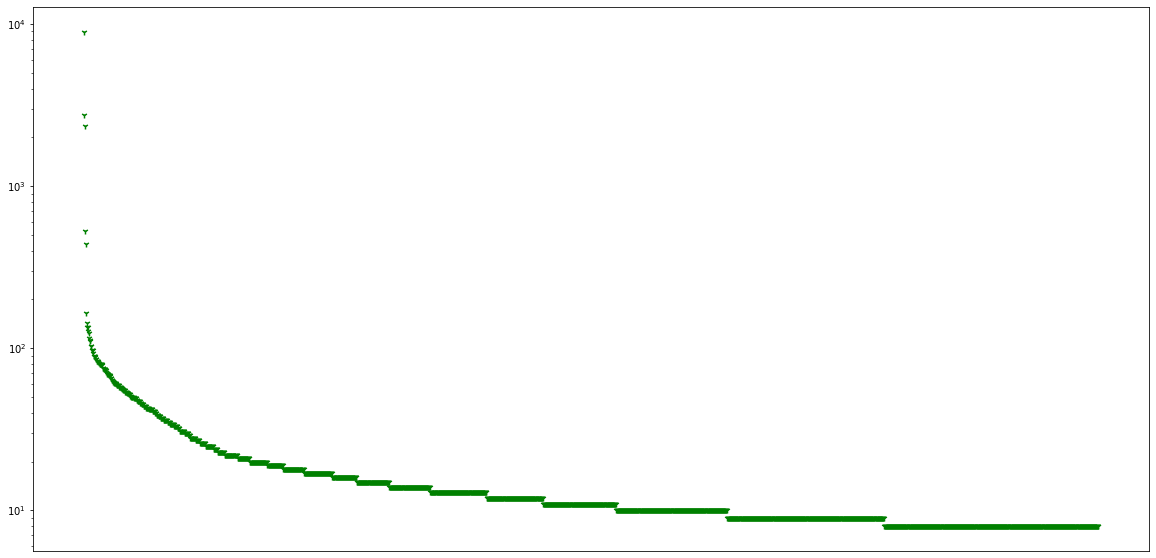

In [19]:
plt.figure(figsize=(20,10))
plt.scatter(degrees['Device'][:2000],degrees['Degree'][:2000], color='g', marker='1')
plt.yscale('log')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

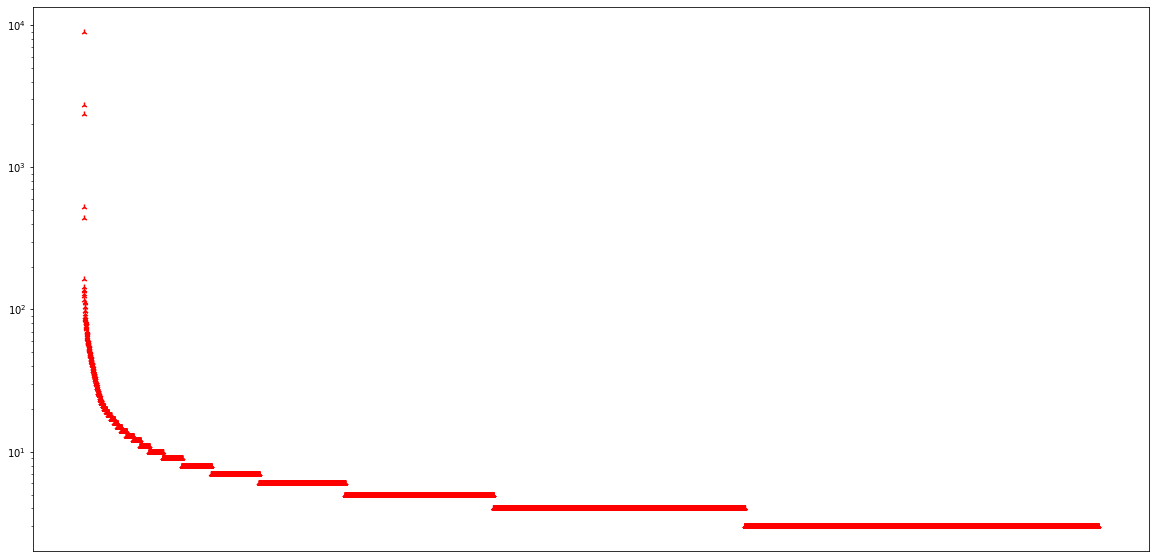

In [20]:
plt.figure(figsize=(20,10))
plt.scatter(degrees_l2['Device'],degrees_l2['Degree'], color='r', marker='2')
plt.yscale('log')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

### Dummy Variables

We'll create a quick and dirty dummy variable creation function. We could use the get_dummies function from pandas but this creates rows instead of doing it inplace which would result in a massive amount of features which would essentially be unhandleable when working with the entire data set.

In [21]:
def dummy(row, data):
    row_vals = data[row].unique()
    row_vals_dict = {}
    for i, key in enumerate(row_vals):
        row_vals_dict[key] = i
    
    return row_vals_dict

In [22]:
user_names_dict = dummy('UserName', process_day_1)
devices_dict = dummy('Device', process_day_1)
processes_dict = dummy('ProcessName', process_day_1)
parent_processes_dict = dummy('ParentProcessName', process_day_1)

dummy_process_day_1 = pd.DataFrame()

dummy_process_day_1['UserName'] = process_day_1['UserName'].map(user_names_dict)
dummy_process_day_1['Device'] = process_day_1['Device'].map(devices_dict)
dummy_process_day_1['ProcessName'] = process_day_1['ProcessName'].map(processes_dict)
dummy_process_day_1['ParentProcessName'] = process_day_1['ParentProcessName'].map(parent_processes_dict)
dummy_process_day_1['DailyCount'] = process_day_1['DailyCount']

In [23]:
dummy_process_day_1

,UserName,Device,ProcessName,ParentProcessName,DailyCount
0,0,0,0,0,1
1,1,1,1,1,1
2,2,2,2,2,1
3,3,3,3,1,1
4,4,4,4,1,1
...,...,...,...,...,...
605208,342,340,67,1,2
605209,11268,1156,159,61,2
605210,5102,2723,174,15,1
605211,7743,6290,139,5,2


So we've converted our object variables into integers successfully!

### Clustering

#### DBSCAN

We'll attempt to run a DBSCAN clustering on this data set now. This will give us a good indication of whether the data set is useful for anomaly detection or not since DBSCAN is effective at picking up anomalous data from unlabelled data. The below is a snippet of the grid search we perform on the HPC which we will later import.

We'll analyse the effectiveness of our parameters through the number of clusters produced, the number of noise points and the silhouette score.

The silhouette score is defined when the number of labels i.e. clusters produced is $ 2 < clusters < samples - 1 $. It takes values in $ [-1,1] $ with -1 being the worst score and 1 being the best score.  

In [24]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [25]:
# eps = [1,2,5,10,25,50,100]
eps = [1]
min_samples = [100,50,25,15,10]

no_clust = []
no_noise = []
sil_score = []
e_m = []

for e in eps:
    for ms in min_samples:
        
        clear_output(wait=True)
        print('Working with eps = {} and min_samples = {}'.format(e,ms))
        
        e_m.append((e,ms))
        
        db = DBSCAN(eps=e, min_samples=ms).fit(dummy_process_day_1)
        labels = db.labels_
        no_clust.append(len(np.unique(labels)))
        no_noise.append(np.sum(np.array(labels) == -1, axis=0))
        
        if len(np.unique(labels)) == 1:
            sil_score.append(0)
        else:
            sil_score.append(metrics.silhouette_score(dummy_process_day_1, labels))

Working with eps = 1 and min_samples = 10


From reference [2] from our bibliography, we would expect min_samples=10 to give us our best results since $ 2 * dim = 10 $, however the data set is likely to contain a lot of noise and is a large data set so this may need to be increased. As for $ \epsilon $, we will use methods such as the elbow method, largest cluster size and noise % to determine this. Silhouette score will also give us a good indicator.

In [26]:
# DBSCAN_parameter_search = pd.read_csv('/HPC Data/Grid Search HPC.csv', compression='gz')

In [27]:
# DBSCAN_parameter_search

#### OPTICS

We attempt the OPTICS clustering algorithm to find anomalies. This algorithm is supposed to run in $\Omega(nlog(n))$ time which is the same as DBSCAN but it has the advantage that it can detect clusters of varying density unlike DBSCAN. We'll see how this runs here.

In [28]:
from sklearn.cluster import OPTICS

In [29]:
try:
    print('Loading Model...')
    opt_clust = pickle.load(open('Models/OPTICS_10.p', 'rb'))
    clear_output()
    print('Model loaded from save.')

except:
    clear_output()
    print('Model not found. Running Model.')
    opt_clust = OPTICS(min_samples=10)
    opt_clust.fit(dummy_process_day_1)
    pickle.dump(opt_clust, open('Models/OPTICS_10.p', 'wb'))

Model loaded from save.


In [30]:
n_events_1 = dummy_process_day_1.shape[0]
opt_labels = opt_clust.labels_[opt_clust.ordering_]
opt_no_clust = len(np.unique(opt_labels))
opt_no_noise = np.sum(np.array(opt_labels) == -1, axis=0)

print('Number of clusters identified: {}. Number of noise points identified: {}.'.format(opt_no_clust,opt_no_noise))

print("Percentage of points in clusters {}. Percentage of points labelled as noise/outliers {}.".format(1-(opt_no_noise/n_events_1),
                                                                                                        opt_no_noise/n_events_1))

Number of clusters identified: 12800. Number of noise points identified: 369900.
Percentage of points in clusters 0.3888102205339278. Percentage of points labelled as noise/outliers 0.6111897794660722.


In [31]:
clust_day_1 = process_day_1
clust_day_1['Cluster'] = opt_labels

<ipython-input-31-5d6b90906af0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_day_1['Cluster'] = opt_labels


In [32]:
anom_day_1 = clust_day_1[clust_day_1['Cluster'] == -1]

In [33]:
pp_anom = anom_day_1.groupby(['ProcessName', 'ParentProcessName']).size().sort_values(ascending=False)

Lets assume that the times where the pair, ProcessName and ParentProcessName, appear once are likely to be our actual anomalies.

In [34]:
pp_anom_1 = pd.DataFrame(pp_anom[pp_anom == 1])
pp_anom_1

0
ProcessName    ParentProcessName   
Proc176570.exe svchost            1
Proc887334.exe Proc510963         1
Proc879348.exe Proc140712         1
Proc887334.exe Proc531545         1
               Proc566619         1
...                              ..
Proc319629.exe Proc042360         1
Proc664351.exe Proc149600.exe     1
               Proc443636         1
               Proc684164         1
wmiprvse.exe   wmiprvse.exe       1

[3120 rows x 1 columns]

In [35]:
print('This data set represents {}% of our original data.'.format(len(pp_anom_1)/process_day_1.shape[0]))

This data set represents 0.005155209818691932% of our original data.


### Authentication Data

In [36]:
authentication_data.head()

,UserName,SrcDevice,DstDevice,Authent Type,Failure,DailyCount
0,User035855,Comp808475,Comp081330,TGS,0,17.0
1,Comp655251$,Comp655251,ActiveDirectory,NetworkLogon,0,350.0
2,User762066,Comp306129,ActiveDirectory,TGS,0,22.0
3,User384215,Comp095190,EnterpriseAppServer,NetworkLogon,0,35.0
4,User043263,Comp883307,Comp384394,TGS,0,2.0


In [37]:
authentication_data.shape

(15953681, 6)

In [38]:
auth_index_list = authentication_data.index.tolist()
auth_start_days = [i for i, e in enumerate(auth_index_list) if e == 0]
auth_start_days.append(len(authentication_data))

#### Red Team Help

We first get the list provided by Alex of all the usernames that were at some point compromised.

In [39]:
rt_auth = list(pd.read_csv('../Data/AuthUserNames.txt', header=None)[0])

We'd like to isolate all source devices that had a compromised user access them. Obviously all the source devices will not have been compromised whenever a compromised username accessed them but this will give an indicator.

In [40]:
rt_srcdevices = authentication_data[authentication_data['UserName'].isin(rt_auth)]['SrcDevice'].unique()

In [41]:
event_nums = []
for i in range(len(auth_start_days)-1):
    authentication_data_day = authentication_data[auth_start_days[i]:auth_start_days[i+1]]
    event_nums.append(authentication_data_day.shape[0])

C:\Users\corri\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\corri\anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\corri\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


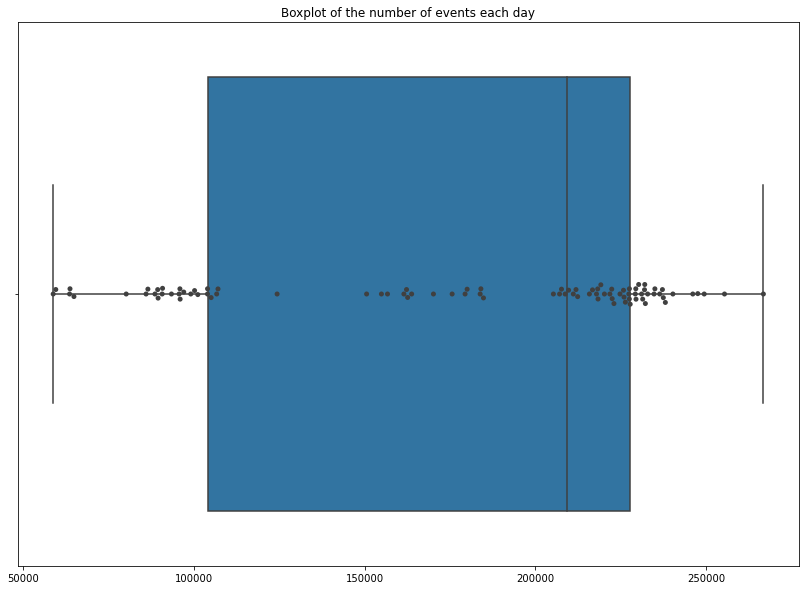

DescribeResult(nobs=90, minmax=(58804, 266843), mean=177263.1222222222, variance=3863358493.726467, skewness=-0.5725685782059318, kurtosis=-1.2383112447309517)

In [42]:
plt.figure(figsize=(14,10))
sns.boxplot(event_nums, orient='v')
sns.swarmplot(event_nums, color=".25")
plt.title('Boxplot of the number of events each day')
plt.show()
stats.describe(np.array(event_nums))

We're better off graphing between SrcDevice and DstDevice. Anomalous connections between these are likely to represent an anomaly whereas data from the process is hard to determine what we're supposed to be graphing.

In [43]:
authentication_G_1 = nx.from_pandas_edgelist(authentication_data[auth_start_days[0]:auth_start_days[1]], source="SrcDevice", target="DstDevice", edge_attr=['DailyCount'])

The first thing we'll look at is whether there are any drastic changes in the degree of the nodes each day - this could be an anomalous day. This includes the daily count on the weighting.

In [44]:
a_1_degrees = pd.DataFrame([(n,d) for n,d in authentication_G_1.degree(weight='DailyCount')])
a_1_degrees.columns = ['SrcDevice', 'Degree']
a_1_degrees = a_1_degrees.sort_values(by='Degree',axis=0,ascending=False)
a_1_degrees

,SrcDevice,Degree
3,ActiveDirectory,1167710.0
135,Comp704126,480395.0
9727,Comp065845,306318.0
10,Comp915658,263854.0
4126,Comp807801,221257.0
...,...,...
9995,Comp838614,1.0
8772,Comp948503,1.0
5705,Comp020600,1.0
10332,Comp631973,1.0


The HTM Studio analysis requires at least 400 rows. Running with 400 rows doesn't give a long enough time frame to look for anomalies so we'll try to divide the days further. From the above analysis, the data contains an average of $177,263$ events, a minimum of $58,804$ and a maximum of $266,843$. If we divide each day into '1 hour' blocks, we obtain $ 90 * 24 = 2,160 $ events which is enough for the HTM module and also creates an average of $\frac{177,263}{6} = 29,543$ events per block and a minimum of $\frac{58,804}{24} = 2450$. The latter is quite a small amount of events but we hope that we can achieve something through this.

In [45]:
# splits a dataframe into n chunks
def split_dataframe(df,n): 
    chunks = list()
    chunk_size = int(np.round(df.shape[0]/n))
    num_chunks = n
    for i in range(num_chunks):
        if i != num_chunks-1:
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
        else:
            chunks.append(df[i*chunk_size:])
    return chunks

In [46]:
def degree_day_splits(data,n):
    
    SrcDevices = list(authentication_data['SrcDevice'].unique())
    degree_days = pd.DataFrame(index=SrcDevices)
    
    for i in range(len(auth_start_days)-1):
        print('Working with day {} of {}.'.format(i+1,len(auth_start_days)-1))
        clear_output(wait=True)

        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        
        if len(chunks) != n:
            print('ERROR: Number of chunks is not {}.'.format(n))
            break
            
        for j in range(n):
            data = chunks[j]
            # create graph
            auth_day_G = nx.from_pandas_edgelist(data,source="SrcDevice",target="DstDevice", edge_attr=['DailyCount'])
            # create degree dictionary
            dict_degrees = {n:d for n,d in auth_day_G.degree(weight='DailyCount')}
            # map dictionary to data frame()
            degree_days[i*n+j] = degree_days.index.to_series().map(dict_degrees)
    
    degree_days = degree_days.fillna(0)
    degree_days = degree_days.transpose()
    
    return degree_days

**NOT uniformly split so unlikly 24 hour splits uniformly.**

- Alex's idea is to split by hours of the data based on the los alamos work structure.
- First week is the 'free friday' (referring to the 9 day work week that Los Alamos have).

In [47]:
degree_days_t = degree_day_splits(authentication_data,24)

Working with day 90 of 90.


In [48]:
degree_days_t

,Comp808475,Comp655251,Comp306129,Comp095190,Comp883307,Comp621781,Comp911231,Comp916004,Comp535288,Comp097283,...,Comp970922,Comp621704,Comp738332,Comp895482,Comp639324,Comp232848,Comp702812,Comp726739,Comp850306,Comp369402
0,177.0,352.0,31.0,35.0,2.0,15.0,17.0,1278.0,6.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.0,1.0,1.0,2.0,1.0,0.0,0.0,3231.0,241.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,106.0,48.0,7.0,321.0,0.0,245.0,13.0,1071.0,6.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16.0,4.0,1.0,1.0,0.0,1.0,41.0,443.0,214.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,7.0,0.0,0.0,0.0,1.0,1039.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,362.0,0.0,0.0,40.0,23.0,0.0,0.0,593.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2156,0.0,2.0,0.0,24.0,0.0,0.0,0.0,315.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2157,0.0,0.0,0.0,23.0,953.0,2.0,0.0,1059.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2158,0.0,5816.0,0.0,0.0,0.0,2.0,0.0,538.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [49]:
degree_days_t.to_csv('Authentication Weighted Degree Days.gz', index_label ='Time', compression='gzip')

We'll isolate out the source computers that are likely to have been compromised and determine whether the HTM model identifies periods of anomalies.

In [50]:
rt_degrees = degree_days_t[rt_srcdevices]
comps = ['Comp984253','Comp916004','Comp127959','Comp620222','Comp107130','ActiveDirectory','Comp177326','Comp526669']
#rt_degrees.to_csv('Red Team Weighted Degree Days.csv', index_label='Time')
rt_degrees[comps].to_csv('Partial Red Team Weighted Degree Days.csv', index_label='Time')

In [51]:
rt_degrees.iloc[:, 0:10]

,EnterpriseAppServer,Comp273168,Comp599337,Comp544870,Comp277798,Comp894088,Comp795424,Comp085042,Comp324282,Comp867735
0,14150.0,399.0,51.0,25.0,1.0,115.0,1.0,1.0,401.0,39.0
1,1212.0,29.0,6.0,911.0,0.0,22.0,0.0,2.0,27.0,97.0
2,791.0,105.0,25.0,662.0,170.0,90645.0,1.0,2.0,0.0,64.0
3,16525.0,8.0,17.0,86.0,0.0,76.0,0.0,0.0,0.0,0.0
4,19829.0,0.0,3.0,8.0,6.0,47.0,0.0,0.0,90.0,4.0
...,...,...,...,...,...,...,...,...,...,...
2155,223.0,0.0,0.0,0.0,44.0,6.0,0.0,0.0,1521.0,0.0
2156,34.0,0.0,2.0,0.0,16.0,25.0,0.0,22.0,0.0,0.0
2157,520.0,48.0,0.0,2.0,0.0,7.0,0.0,142.0,0.0,0.0
2158,445.0,0.0,0.0,0.0,0.0,8.0,0.0,44.0,0.0,0.0


We need to make this data easier to handle. The best way to do this is to isolate out rows that are likely to contain anomalies and remove those that are unlikely to. We first attempt this with K-means to determine if we have any anomalies - we'll run a test with EnterpriseAppServer data.

In [72]:
easrt_degrees = rt_degrees.iloc[:, 0]

In [73]:
from sklearn.cluster import KMeans

For n_clusters = 2 The average silhouette_score is : 0.9744285428338011
For n_clusters = 3 The average silhouette_score is : 0.7663907983163978
For n_clusters = 4 The average silhouette_score is : 0.7642354082112698
For n_clusters = 5 The average silhouette_score is : 0.7160766607050397
For n_clusters = 6 The average silhouette_score is : 0.6955445210733576
For n_clusters = 7 The average silhouette_score is : 0.6053061624695643
For n_clusters = 8 The average silhouette_score is : 0.5950995645886274
For n_clusters = 10 The average silhouette_score is : 0.5937633341462568
For n_clusters = 16 The average silhouette_score is : 0.56357519289807
For n_clusters = 24 The average silhouette_score is : 0.5573436979951467


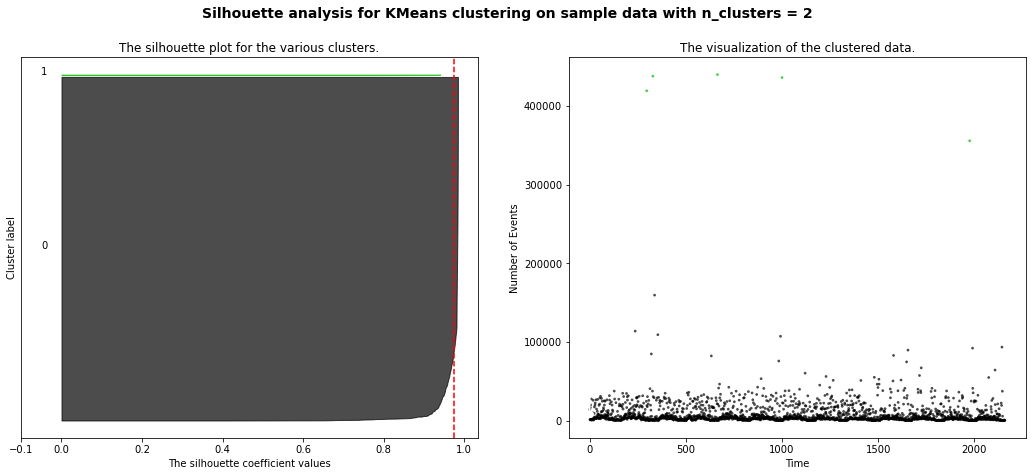

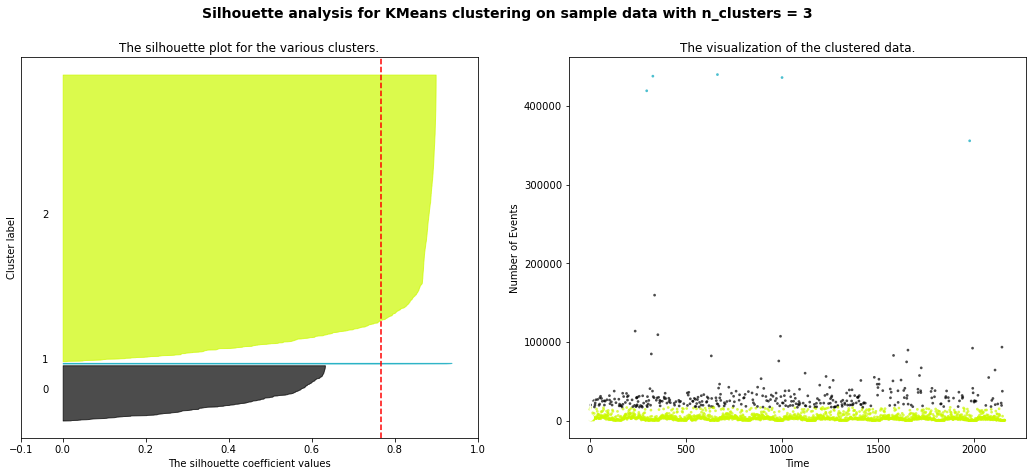

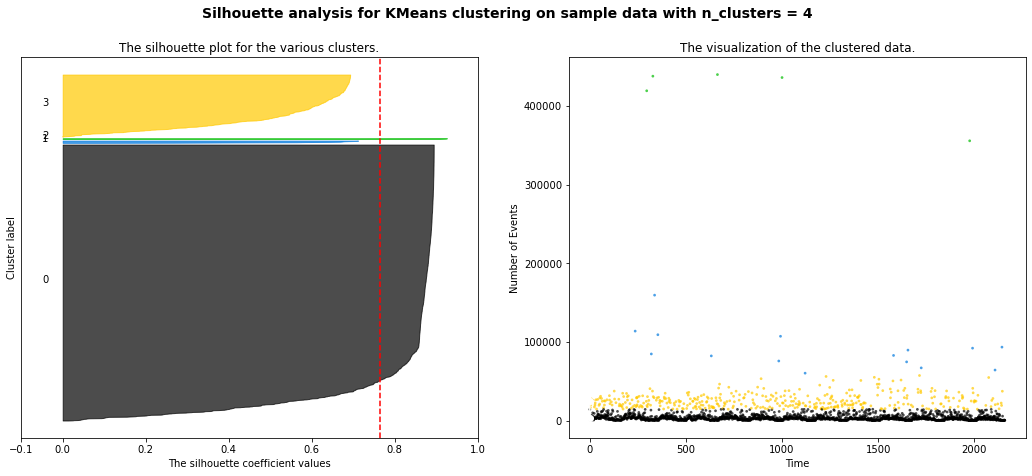

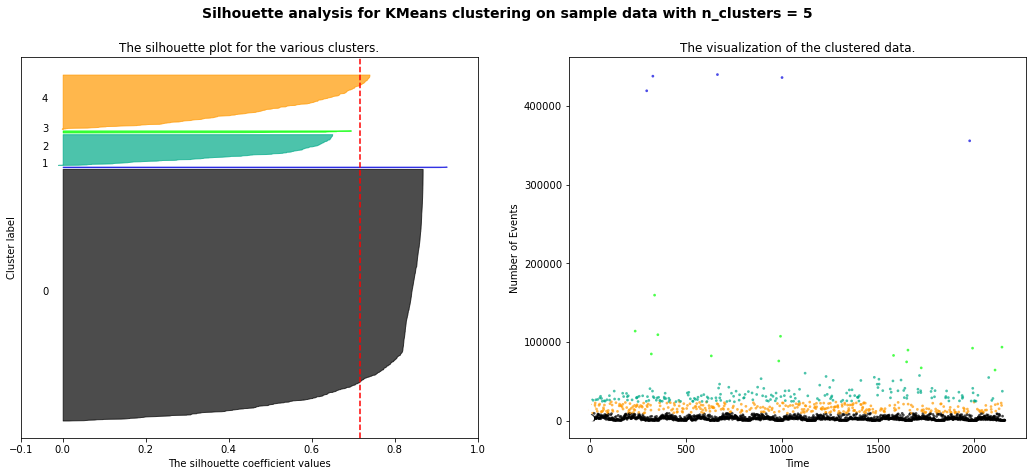

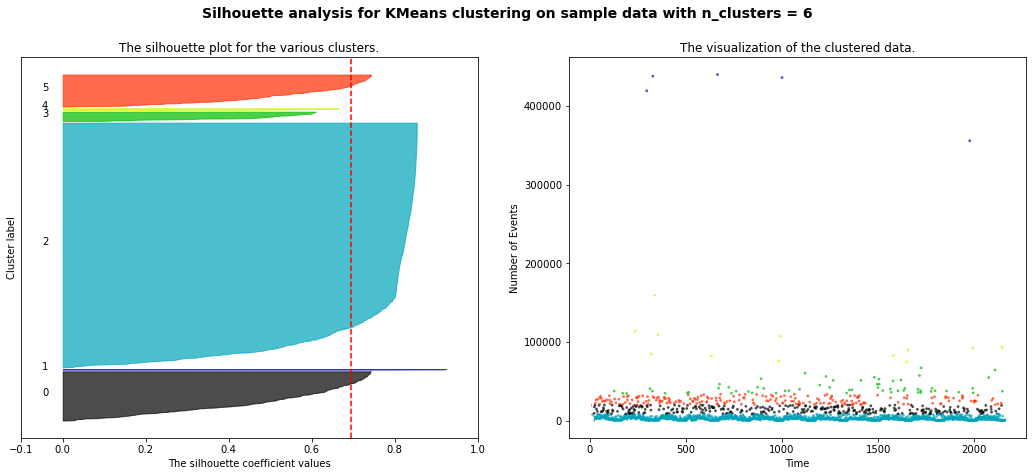

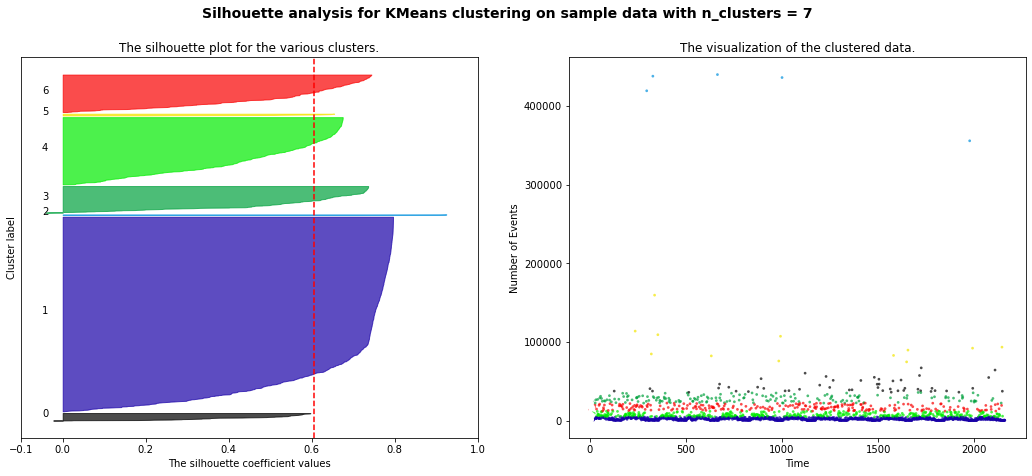

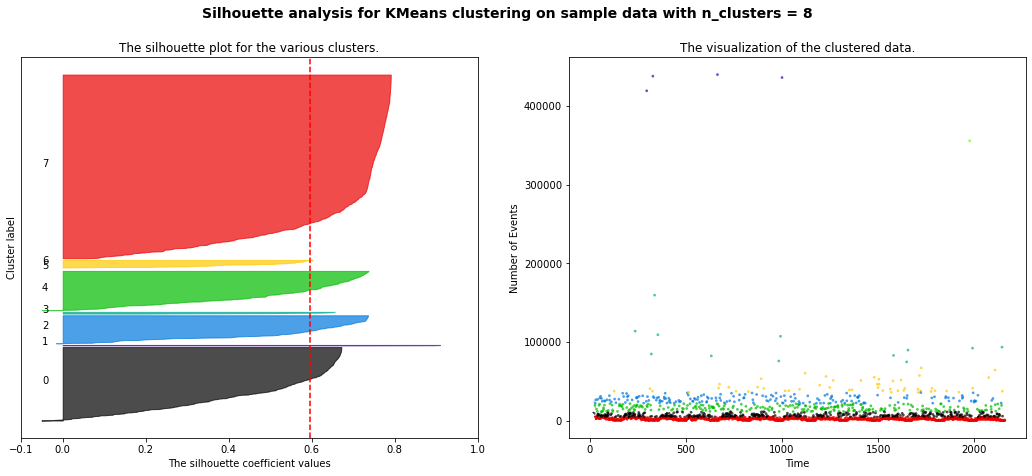

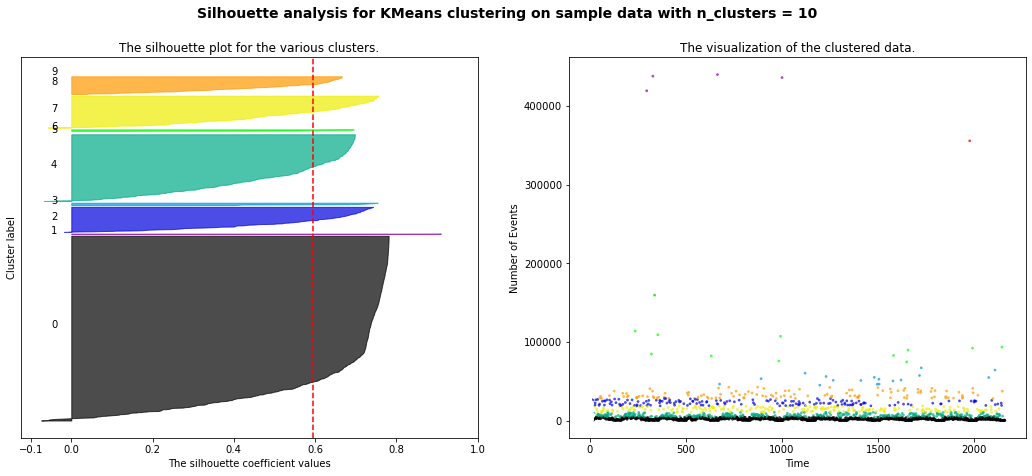

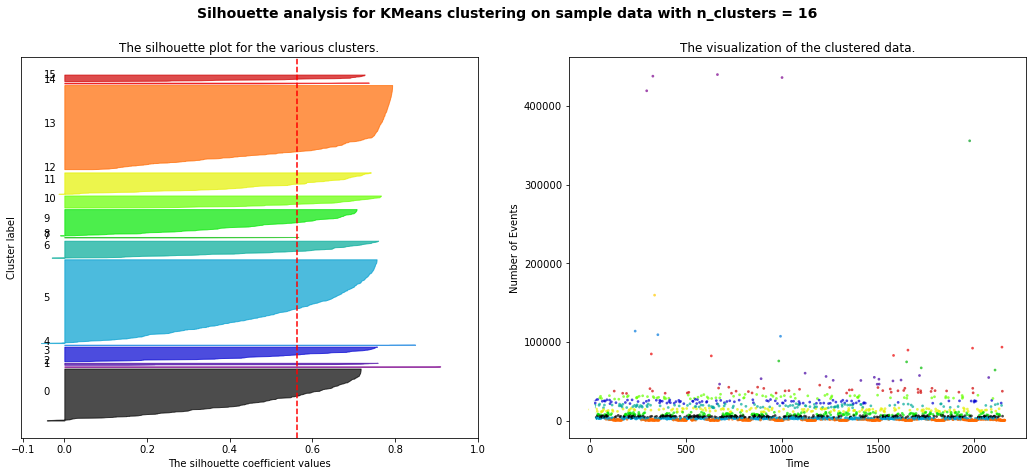

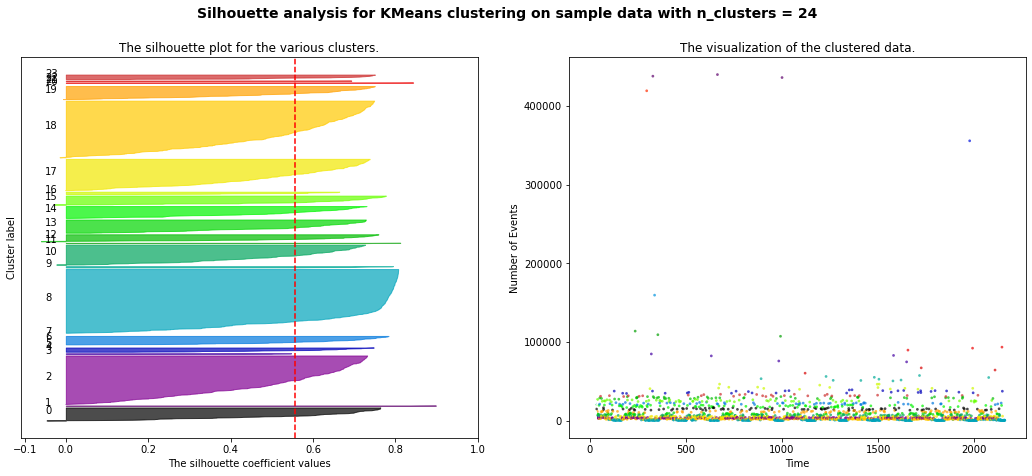

In [98]:
no_clusters = [2,3,4,5,6,7,8,10,16,24]

for n_c in no_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    clusterer = KMeans(n_clusters=n_c, random_state=10)
    cluster_labels = clusterer.fit_predict(np.array(easrt_degrees).reshape(-1, 1))
    
    silhouette_avg = silhouette_score(np.array(easrt_degrees).reshape(-1,1), cluster_labels)
    print("For n_clusters =", n_c,
          "The average silhouette_score is :", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(np.array(easrt_degrees).reshape(-1,1), cluster_labels)
    
    y_lower = 10
    
    for i in range(n_c):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_c)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_c)
    ax2.scatter(easrt_degrees.index, easrt_degrees, marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.plot(centers[:, 0],  marker='o',
                c="white", alpha=1)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Number of Events")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_c),
                 fontsize=14, fontweight='bold')

plt.show()

We want silhouette score to be closest to 1, thus with this data set, we get the best silhouette score when we use 2 clusters in KMeans. We now attempt this on a random sample of the dataset (without the graphs) and determine how many clusters to use. We use the random sample since performing this for the entire data set would be a very long process - we'll take a sample of 10% which gives us 1820 samples.

In [138]:
def cluster_size_search(data):
    
    no_clusters = [2,3,4,5,6,7,8,10,16,24]
    return_sil = []
    
    for n_c in no_clusters:

        clusterer = KMeans(n_clusters=n_c, random_state=10)
        cluster_labels = clusterer.fit_predict(np.array(data).reshape(-1, 1))
        
        silhouette_avg = silhouette_score(np.array(data).reshape(-1,1), cluster_labels)
        return_sil.append(silhouette_avg)
    
    return return_sil

In [139]:
sil_scores = pd.DataFrame(np.empty((0,10)))
sil_scores.columns = [2,3,4,5,6,7,8,10,16,24]

entries = random.sample(range(degree_days_t.shape[1]), int(degree_days_t.shape[1]/10))

s_time = datetime.datetime.now()

for e,i in enumerate(entries):
    clear_output(wait=True)
    print('Working with sample {} of {}.'.format(e+1, len(entries)))
    data = degree_days_t.iloc[:, i]
    data_scores = cluster_size_search(data)
    sil_scores.loc[i] = data_scores
    
e_time = datetime.datetime.now()

print('Time taken for {} iterations: {}.'.format(len(entries),e_time-s_time))

Working with sample 1819 of 1819.


C:\Users\corri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\corri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\corri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\corri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return self.fit(

Time taken for 1819 iterations: 0:29:27.730849.


C:\Users\corri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\corri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (24). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


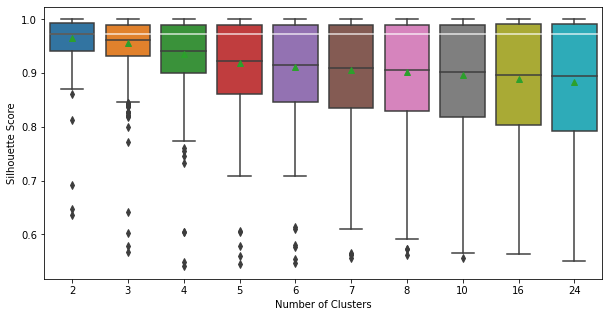

In [153]:
plt.figure(figsize=(10,5))
sns.boxplot(showmeans=True, data=sil_scores)
plt.axhline(y=sil_scores[2].median(), color='w', linestyle='-',alpha=0.8)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [154]:
sil_scores.describe()

,2,3,4,5,6,7,8,10,16,24
count,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000
mean,0.965518,0.956035,0.935490,0.917901,0.911612,0.906164,0.902177,0.896678,0.888791,0.884019
std,0.032173,0.040797,0.057792,0.070289,0.075163,0.079336,0.082166,0.087009,0.094400,0.101034
min,0.636276,0.567159,0.540336,0.544781,0.546505,0.555902,0.561755,0.556841,0.562725,0.551127
25%,0.941895,0.932231,0.900142,0.861039,0.846927,0.835997,0.829457,0.818875,0.803014,0.793018
50%,0.973242,0.962407,0.940720,0.922970,0.915783,0.909042,0.905477,0.902356,0.896451,0.894199
75%,0.993456,0.990276,0.989886,0.989296,0.989060,0.989063,0.989057,0.989288,0.991057,0.992168
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We see that the median and mean for the results decrease as we increase the number of clusters. The scores are stil high, aremaining above 0.9 until we reach 10 clusters and therefore using any of these numbers of clusters should work well. In our case however, we will use 2 clusters. This allows us to easily group events into one major cluster with an outlier cluster too that will be called anomalous depending on thresholds we set.

We'll plot a clustering for 10 random Source Devices below.

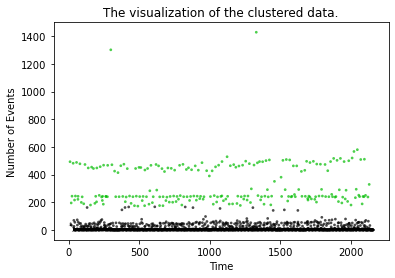

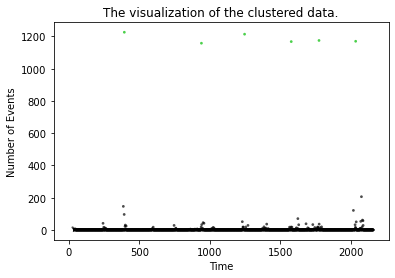

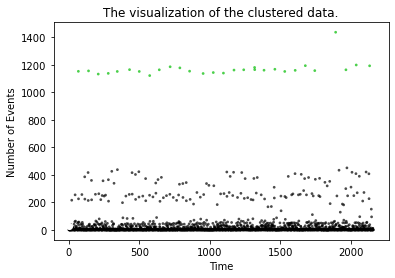

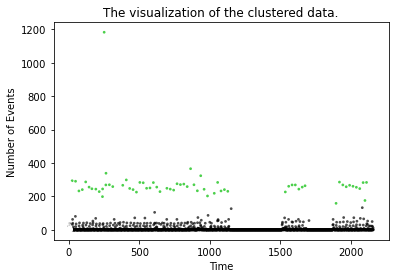

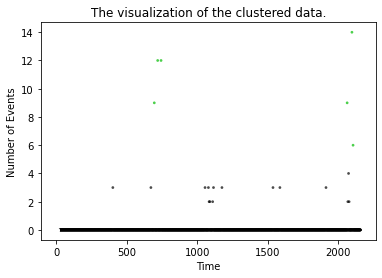

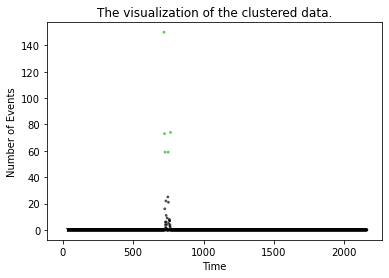

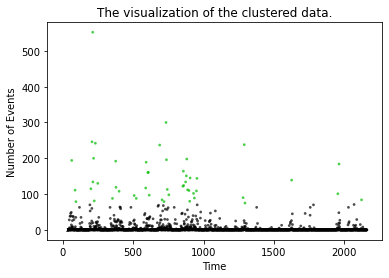

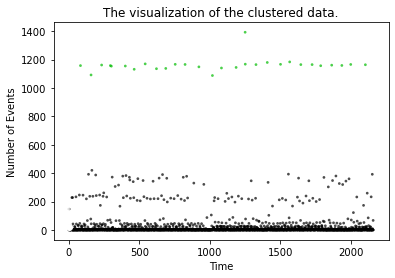

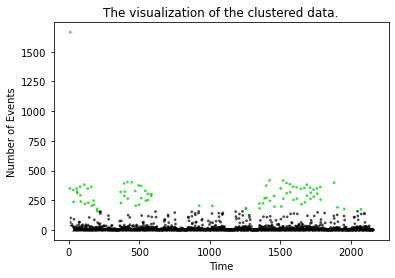

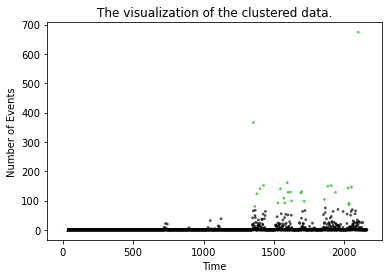

In [160]:
plot_entries = random.sample(range(degree_days_t.shape[1]), 10)

for i in plot_entries:
    
    fig = plt.plot(figsize=(12,12))
    
    clusterer = KMeans(n_clusters=2, random_state=10)
    cluster_labels = clusterer.fit_predict(np.array(degree_days_t.iloc[:, i]).reshape(-1, 1))

    # Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / 2)
    plt.scatter(degree_days_t.iloc[:, i].index, degree_days_t.iloc[:, i], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    plt.plot(centers[:, 0],  marker='o',
                c="white", alpha=1)

    plt.title("The visualization of the clustered data.")
    plt.xlabel("Time")
    plt.ylabel("Number of Events")

    plt.show()

So we see that KMeans isn't hugely effective in this aspect. Points that we wouldn't likely consider as anomalies are grouped into the anomalous data points by the method due to it not understanding time particularly well - we see periodic increases that are considered anomalies however in the larger scheme of things, they are unlikely to be as they are just periodic increases.

One issue we face is that the Euclidean distance isn't particularly well suited for time series data. One recommendation made in reference [9] is to use the dynamic time warping metric. We attempted this below with TimeSeruesJKMeans from tslearn however this seems to run for way too long for any effective use within our data.

#### Dynamic Time Warping

In [165]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

In [179]:
eas_scaler = StandardScaler()
eas_scaler.fit(np.array(rt_degrees.iloc[:, 0]).reshape(-1,1))
eas_scaled = eas_scaler.transform(np.array(rt_degrees.iloc[:, 0]).reshape(-1,1))

In [181]:
# print("Soft-DTW k-means")
# no_clusters = [4,5,6,7,8,10,16,24]

# for n_c in no_clusters:
#     print(n_c)
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(18, 7)
    
#     clusterer = TimeSeriesKMeans(n_clusters=n_c, 
#                                  metric="softdtw",
#                                  metric_params={"gamma": .},
#                                  verbose=True,
#                                  random_state=10)
#     cluster_labels = clusterer.fit_predict(eas_scaled)
    
#     silhouette_avg = silhouette_score(eas_scaled, cluster_labels)
#     print("For n_clusters =", n_c,
#           "The average silhouette_score is :", silhouette_avg)
    
#     sample_silhouette_values = silhouette_samples(eas_scaled, cluster_labels)
    
#     y_lower = 10
    
#     for i in range(n_c):
#         # Aggregate the silhouette scores for samples belonging to
#         # cluster i, and sort them
#         ith_cluster_silhouette_values = \
#             sample_silhouette_values[cluster_labels == i]

#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_c)
#         ax1.fill_betweenx(np.arange(y_lower, y_upper),
#                           0, ith_cluster_silhouette_values,
#                           facecolor=color, edgecolor=color, alpha=0.7)

#         # Label the silhouette plots with their cluster numbers at the middle
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#         # Compute the new y_lower for next plot
#         y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title("The silhouette plot for the various clusters.")
#     ax1.set_xlabel("The silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")

#     # The vertical line for average silhouette score of all the values
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_c)
#     ax2.scatter(easrt_degrees.index, rt_degrees.iloc[:, 1000], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
    
#     # Draw white circles at cluster centers
#     ax2.plot(centers[:, 0],  marker='o',
#                 c="white", alpha=1)

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Time")
#     ax2.set_ylabel("Number of Events")

#     plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
#                   "with n_clusters = %d" % n_c),
#                  fontsize=14, fontweight='bold')

# plt.show()

#### Isolation Forest

We try an isolation forest on this data.

In [195]:
eas_data = pd.DataFrame(eas_scaled)

if_model = IsolationForest(contamination=0.005)
if_predictions = if_model.fit_predict(eas_data)

In [196]:
eas_data[0]

0       0.217791
1      -0.342588
2      -0.360823
3       0.320659
4       0.463764
          ...   
2155   -0.385425
2156   -0.393611
2157   -0.372561
2158   -0.375809
2159   -0.386031
Name: 0, Length: 2160, dtype: float64

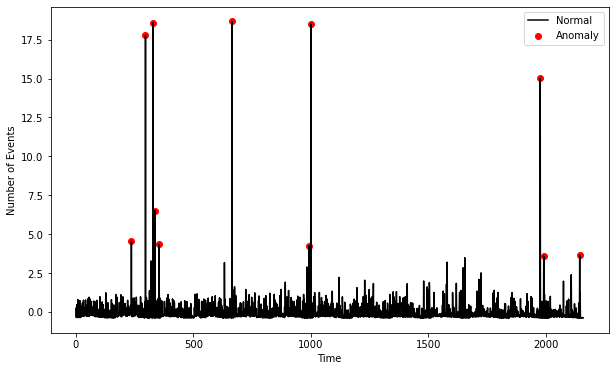

In [197]:
fig, ax = plt.subplots(figsize=(10,6))
a = eas_data.loc[if_predictions == -1]
ax.plot(eas_data.index, eas_data[0], color='black', label='Normal')
ax.scatter(a.index, a, color='red', label='Anomaly')
ax.set_xlabel("Time")
ax.set_ylabel("Number of Events")
plt.legend()
plt.show()

### WLS Data

In [ ]:
def WLS_reader(day):
    
    json_data_no_proc = [] 

    s_time = datetime.datetime.now()

    with bz2.open('C:\\Users\\corri\\Downloads\\wls_day-' + str(day) + '.bz2',"rt") as f:
        for line in f:
            ln = json.loads(line)
            if ('LogonType' in ln.keys()) and ('ProcessName' not in ln.keys()):
                json_data_no_proc.append(ln)
            else:
                pass

    wls_auths_no_proc = pd.DataFrame(json_data_no_proc)

    e_time = datetime.datetime.now()

    print('Reading data took: {}.'.format(e_time - s_time))

    print('{} lines read.'.format(wls_auths_no_proc.shape[0]))
    
    return wls_auths_no_proc

In [ ]:
def degree_splits(data,n):
    
    UserNames = list(authentication_data['UserName'].unique())
    degree_sets = pd.DataFrame(index=UserNames)

    chunks = split_dataframe(data,n)

    if len(chunks) != n:
        print('ERROR: Number of chunks is not {}.'.format(n))

    for j in range(n):
        clear_output(wait=True)
        print('Working with section {} of {}.'.format(j+1,n))
        data = chunks[j]
        # create graph
        auth_set_G = nx.from_pandas_edgelist(data,source="UserName",target="LogHost")
        # create degree dictionary
        dict_degrees = {n:d for n,d in auth_set_G.degree()}
        # map dictionary to data frame()
        degree_sets[j] = degree_sets.index.to_series().map(dict_degrees)

    degree_sets = degree_sets.fillna(0)
    degree_sets = degree_sets.transpose()

    return degree_sets

Reading in the data keeping only entries with a Logon Type and without a Process Name gives 5,940,354 entries for a single day.

In [ ]:
day_62_auths_no_proc = WLS_reader(62)

In [ ]:
day_62_auths_no_proc.head()

In [ ]:
day_62_auths_no_proc.tail()

In [ ]:
authentication_types_no3 = list(day_62_auths_no_proc.groupby('LogonType').size())
authentication_types_no3.pop(2)
types_index = list(day_62_auths_no_proc.groupby('LogonType').size().index)
types_index.pop(2)
plt.figure()
plt.bar(x=types_index,height=authentication_types_no3)
plt.show()

From reading the data, the start point for any authentication is the UserName and the end point is the LogHost. Similar to the summary analysis, we create a graph and then iterate over this to determine the number of connections from each username. We define a similar function although this only works with one day.

In [ ]:
degrees_62 = degree_splits(day_62_auths_no_proc,8)

In [ ]:
degrees_62

In [ ]:
day_63_auths_no_proc = WLS_reader(63)

In [ ]:
day_63_auths_no_proc.head()

In [ ]:
day_63_auths_no_proc.tail()

In [ ]:
degrees_63 = degree_splits(day_63_auths_no_proc,8)
degrees_63

### References

1. [Read JSON file with pandas](https://pandas.pydata.org/docs/user_guide/io.html#json)
2. [Welch's Test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
3. [Combining p-values](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.combine_pvalues.html)
4. [LANL Work Times](https://www.lanl.gov/careers/employees-retirees/new-hires/benefit-options/time-off.php)
5. [LANL Documentation](https://arxiv.org/pdf/1708.07518.pdf)
6. [Reading .bz2 JSON](https://stackoverflow.com/questions/48078567/how-to-parse-wikidata-json-bz2-file-using-python)
7. [Silhouette Score Plotting](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
8. [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
9. [Block Commenting](https://stackoverflow.com/questions/29885371/how-do-i-block-comment-in-jupyter-notebook)